# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

# Data Preparation

In [2]:
df = pd.read_excel('raw-customer-churn-data.xlsx')

In [3]:
df.duplicated().any()

True

In [4]:
df.drop_duplicates(subset=['Name'], keep=False, inplace=True)

In [5]:
df.duplicated().any()

False

In [6]:
df.isna().sum()

Name                0
Gender              1
Age                 1
Payment Method      0
Churn              96
LastTransaction     0
dtype: int64

In [7]:
def missing_data(df):
    miss1 = pd.DataFrame(df.isna().sum()).reset_index()
    miss1.columns = ['columns', 'Total']
    miss2 = pd.DataFrame(df.isna().sum()/df.shape[0]*100).reset_index()
    miss2.columns = ['columns', '%']
    miss = miss1.merge(miss2, how='inner', on='columns')
    return miss[miss['Total']!=0]
missing_data(df) 

,columns,Total,%
1,Gender,1,0.100301
2,Age,1,0.100301
4,Churn,96,9.628887


# Data Handling & Manipulation

In [8]:
df['Gender'].unique()

array(['male', 'female', '   female', 'm', nan], dtype=object)

<AxesSubplot:xlabel='Gender', ylabel='count'>

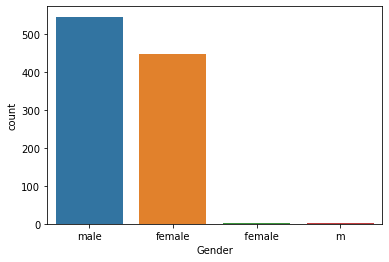

In [9]:
# df[df['Gender'].isna()]
# df['Gender'].iloc[8] = 'male'
sns.countplot(df['Gender'])

In [10]:
mode_gender = df['Gender'].mode()[0]
df['Gender'] = df['Gender'].fillna(mode_gender)

df['Gender'] = df['Gender'].replace("   female","female")
df['Gender'] = df['Gender'].replace("m", "male")

<AxesSubplot:xlabel='Age', ylabel='Density'>

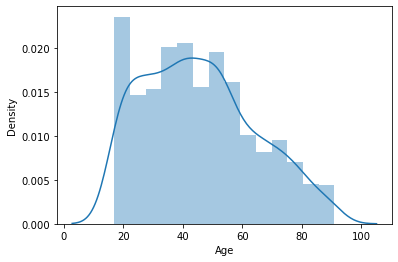

In [11]:
sns.distplot(df["Age"], kde=True)

In [12]:
median_age = round(df['Age'].median())
df['Age'] = df['Age'].fillna(median_age)
df['Age'] = df['Age'].astype(int)

In [13]:
df['Churn'].unique()

array(['loyal', 'churn', nan], dtype=object)

<AxesSubplot:xlabel='Churn', ylabel='count'>

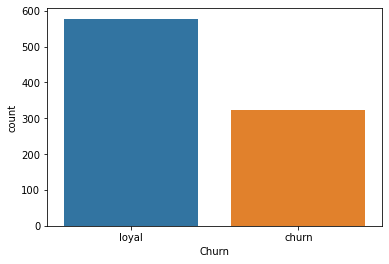

In [14]:
sns.countplot(df['Churn'])

In [15]:
df = df.dropna()

In [16]:
Gender         = {"male" : 0, "female" : 1}
Payment_Method = {"credit card" : 0, "cheque" : 1, "cash" : 2}
Churn          = {"loyal" : 0, "churn" : 1}

data = [df]

for dataset in data:
    dataset['Gender'] = dataset['Gender'].map(Gender)
    dataset['Payment Method'] = dataset['Payment Method'].map(Payment_Method)
    dataset['Churn'] = dataset['Churn'].map(Churn)

# Visualization

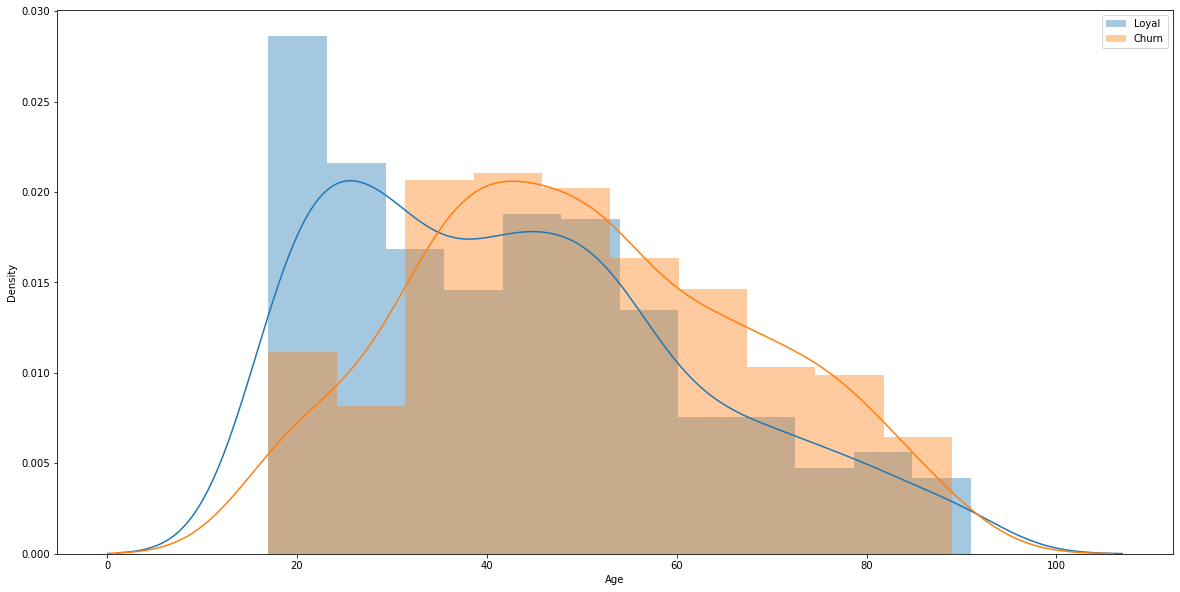

In [17]:
plt.figure(figsize=(20,10))
sns.distplot(df[df['Churn']==0]['Age'], label='Loyal')
sns.distplot(df[df['Churn']==1]['Age'], label='Churn')
plt.legend()
plt.show()

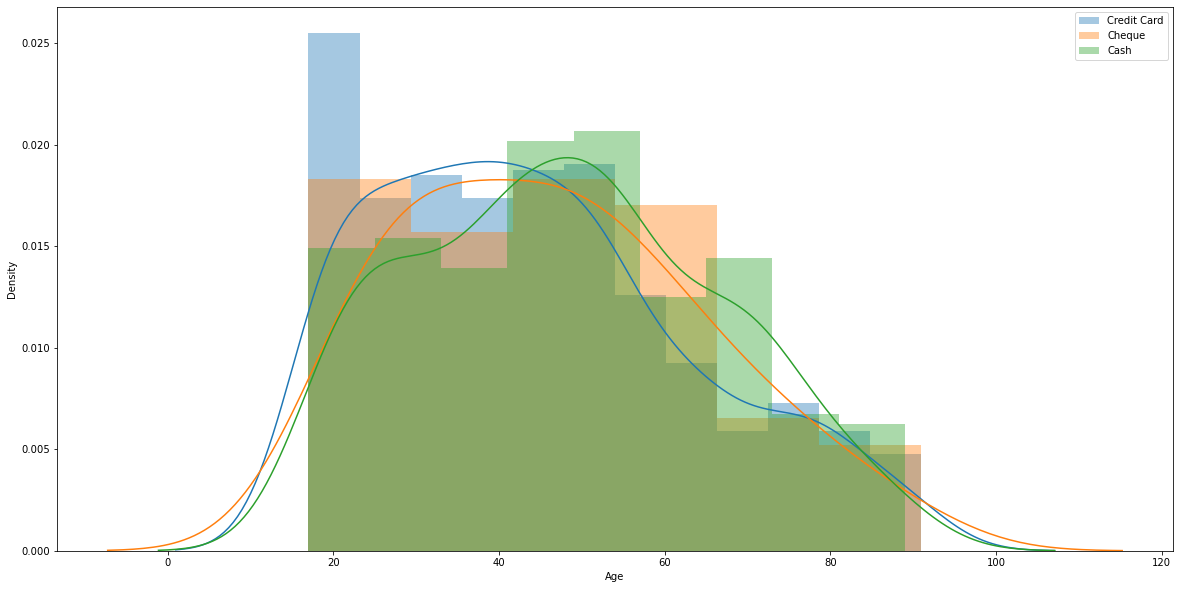

In [18]:
plt.figure(figsize=(20,10))
sns.distplot(df[df['Payment Method']==0]['Age'], label='Credit Card')
sns.distplot(df[df['Payment Method']==1]['Age'], label='Cheque')
sns.distplot(df[df['Payment Method']==2]['Age'], label='Cash')
plt.legend()
plt.show()

In [19]:
age = []

for i in df['Age']:
    if i >= 17 and i < 65:
        age.append(0)
    elif i >= 65 and i < 100:
        age.append(1)
        
df['Age'] = age

In [20]:
df = df.drop(['Name'], axis=1)

# Modeling

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel, SelectPercentile
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [22]:
train_var = df.drop(['Churn'], axis=1)
test_var = df['Churn']
x_train, x_test, y_train, y_test = train_test_split(train_var, test_var, test_size=0.2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((720, 4), (720,), (181, 4), (181,))

In [23]:
std_scaler = StandardScaler()
std_scaler.fit(x_train)
x_train_std = std_scaler.transform(x_train)
x_test_std = std_scaler.transform(x_test)

(1. Confusion matrix, 2. Accuracy, 3. Precision, 4. Recall, 5. Specificity, 6. F1 score, 7. Precision-Recall or PR curve, 8. ROC (Receiver Operating Characteristics)

Average cross validation score: 0.808
[[99 22]
 [10 50]]
accuracy: 0.823
precision: 0.694
recall: 0.833
specificity: 0.818
F1 Score: 0.758
ROC: 0.618


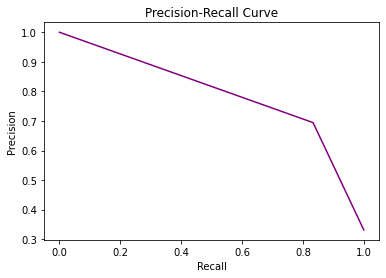

99 22 10 50


In [24]:
logreg = LogisticRegression(max_iter=500).fit(x_train_std, y_train)
scores = cross_val_score(logreg, x_train_std, y_train, cv=5)
logreg_pred = logreg.predict(x_test_std)
print("Average cross validation score: {:.3f}".format(scores.mean()))
print(confusion_matrix(y_test, logreg_pred))
print("accuracy: {:.3f}".format(logreg.score(x_test_std, y_test)))
print("precision: {:.3f}".format(precision_score(y_test, logreg_pred)))
print("recall: {:.3f}".format(recall_score(y_test, logreg_pred)))

tn, fp, fn, tp = confusion_matrix(y_test, logreg_pred).ravel()
print("specificity: {:.3f}".format(tn/(tn+fp)))
print("F1 Score: {:.3f}".format(f1_score(y_test, logreg_pred)))

print("ROC: {:.3f}".format(roc_auc_score(y_test, logreg.predict_proba(x_test)[:, 1])))

precision, recall, thresholds = precision_recall_curve(y_test, logreg_pred)
#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()   

print(tn, fp, fn, tp)
#tp yg asli hidup, model menyatakan benar hidup
#tn yg asli mati, model menyatakan benar mati
#fp yg asli mati, model prediksi hidup
#fn yg asli hidup, model prediksi mati

Average cross validation score: 0.744
[[92 29]
 [24 36]]
accuracy: 0.779
precision: 0.554
recall: 0.600
specificity: 0.760
F1 Score: 0.576
ROC: 0.693


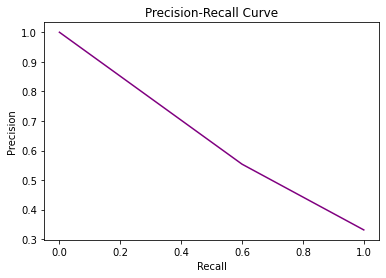

In [25]:
tree = DecisionTreeClassifier().fit(x_train, y_train)
scores = cross_val_score(tree, x_train, y_train, cv=5)
tree_pred = tree.predict(x_test)
print("Average cross validation score: {:.3f}".format(scores.mean()))
print(confusion_matrix(y_test, tree_pred))
print("accuracy: {:.3f}".format(tree.score(x_test_std, y_test)))
print("precision: {:.3f}".format(precision_score(y_test, tree_pred)))
print("recall: {:.3f}".format(recall_score(y_test, tree_pred)))

tn, fp, fn, tp = confusion_matrix(y_test, tree_pred).ravel()
print("specificity: {:.3f}".format(tn/(tn+fp)))
print("F1 Score: {:.3f}".format(f1_score(y_test, tree_pred)))

print("ROC: {:.3f}".format(roc_auc_score(y_test, tree.predict_proba(x_test)[:, 1])))

precision, recall, thresholds = precision_recall_curve(y_test, tree_pred)
#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()   


Average cross validation score: 0.749
[[88 33]
 [22 38]]
accuracy: 0.779
precision: 0.535
recall: 0.633
specificity: 0.727
F1 Score: 0.580
ROC: 0.758


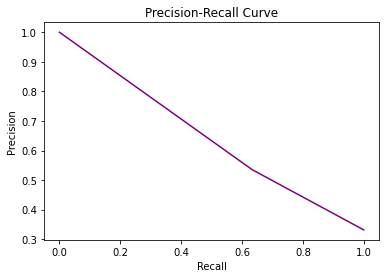

In [26]:
random_forest = RandomForestClassifier().fit(x_train, y_train)
scores = cross_val_score(random_forest, x_train, y_train, cv=5)
rf_pred = random_forest.predict(x_test)
print("Average cross validation score: {:.3f}".format(scores.mean()))
print(confusion_matrix(y_test, rf_pred))
print("accuracy: {:.3f}".format(random_forest.score(x_test_std, y_test)))
print("precision: {:.3f}".format(precision_score(y_test, rf_pred)))
print("recall: {:.3f}".format(recall_score(y_test, rf_pred)))

tn, fp, fn, tp = confusion_matrix(y_test, rf_pred).ravel()
print("specificity: {:.3f}".format(tn/(tn+fp)))
print("F1 Score: {:.3f}".format(f1_score(y_test, rf_pred)))

print("ROC: {:.3f}".format(roc_auc_score(y_test, random_forest.predict_proba(x_test)[:, 1])))

precision, recall, thresholds = precision_recall_curve(y_test, rf_pred)
#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()   

Average cross validation score: 0.699
[[96 25]
 [29 31]]
accuracy: 0.331
precision: 0.554
recall: 0.517
specificity: 0.793
F1 Score: 0.534
ROC: 0.718


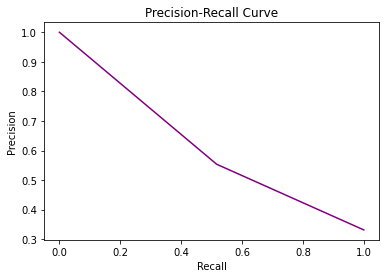

In [27]:
knn = KNeighborsClassifier().fit(x_train, y_train)
scores = cross_val_score(knn, x_train, y_train, cv=5)
knn_pred = knn.predict(x_test)
print("Average cross validation score: {:.3f}".format(scores.mean()))
print(confusion_matrix(y_test, knn_pred))
print("accuracy: {:.3f}".format(knn.score(x_test_std, y_test)))
print("precision: {:.3f}".format(precision_score(y_test, knn_pred)))
print("recall: {:.3f}".format(recall_score(y_test, knn_pred)))

tn, fp, fn, tp = confusion_matrix(y_test, knn_pred).ravel()
print("specificity: {:.3f}".format(tn/(tn+fp)))
print("F1 Score: {:.3f}".format(f1_score(y_test, knn_pred)))

print("ROC: {:.3f}".format(roc_auc_score(y_test, knn.predict_proba(x_test)[:, 1])))

precision, recall, thresholds = precision_recall_curve(y_test, knn_pred)
#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()   


Average cross validation score: 0.672
[[88 33]
 [22 38]]
accuracy: 0.669
precision: 0.535
recall: 0.633
specificity: 0.727
F1 Score: 0.580
ROC: 0.713


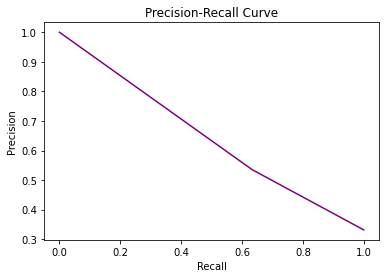

In [28]:
svm = SVC(probability=True).fit(x_train, y_train)
scores = cross_val_score(svm, x_train, y_train, cv=5)
svm_pred = random_forest.predict(x_test)
print("Average cross validation score: {:.3f}".format(scores.mean()))
print(confusion_matrix(y_test, svm_pred))
print("accuracy: {:.3f}".format(svm.score(x_test_std, y_test)))
print("precision: {:.3f}".format(precision_score(y_test, svm_pred)))
print("recall: {:.3f}".format(recall_score(y_test, svm_pred)))

tn, fp, fn, tp = confusion_matrix(y_test, svm_pred).ravel()
print("specificity: {:.3f}".format(tn/(tn+fp)))
print("F1 Score: {:.3f}".format(f1_score(y_test, svm_pred)))

print("ROC: {:.3f}".format(roc_auc_score(y_test, svm.predict_proba(x_test)[:, 1])))

precision, recall, thresholds = precision_recall_curve(y_test, svm_pred)
#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()   
